In [1]:
import os
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import h5py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils import shuffle


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from global_config import ROOT_DIR, emotion_id_to_emotion_abr, conf_cmap
from src.utils.helpers import mapper
from src.analysis.supervised_learning.evaluation.confusion_matrix import ConfusionMatrixCreator

In [5]:
input_path = os.path.join(ROOT_DIR,'files/out/functionals/video_data_functionals.hdf5')
output_path = os.path.join(ROOT_DIR,'files/out/functionals/supervised_learning/video')

In [6]:
f = h5py.File(input_path, 'r')
_X = np.array(f['x'])
y = np.array(f['y'])
groups = np.array(f['groups'])
feature_names = f['feature_names'].asstr()
for k in f.attrs.keys():
    print(f"{k} : {f.attrs[k]}")

group_type : twinned
query : SELECT filename,
video_id,
emotion_1_id,
AU01_r,
AU02_r,
AU04_r,
AU05_r,
AU06_r,
AU07_r,
AU09_r,
AU10_r,
AU12_r,
AU14_r,
AU15_r,
AU17_r,
AU20_r,
AU23_r,
AU25_r,
AU26_r,
AU45_r
FROM openface
WHERE success = 1 
AND confidence >= 0.98 
AND mix = 0;


In [7]:
n_groups = len(np.unique(groups))
n_features = _X.shape[1]
n_classes = len(np.unique(y))

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(_X)

In [9]:
X, y, groups = shuffle(X, y, groups)

In [10]:
def plot_conf_matrix(df_cm, title):
    plt.figure(figsize=(20,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)

In [11]:
def evaluate_scores(X, y, groups, clf, scoring_method):
    logo = LeaveOneGroupOut()
    
    # get scores
    scores = cross_validate(X=X, y=y,
                            estimator           = clf,
                            scoring             = [scoring_method],
                            cv                  = logo.split(X=X,groups=groups),
                            verbose             = 1,
                            n_jobs              = -1,
                            return_train_score  = True                        
                           )
    
    print('printing {} measures'.format(scoring_method))
    print('avg (train):', np.mean(scores['train_{}'.format(scoring_method)]))
    print('std (train):', np.std(scores['train_{}'.format(scoring_method)]))
    print('avg (validation):', np.mean(scores['test_{}'.format(scoring_method)]))
    print('std (validation):', np.std(scores['test_{}'.format(scoring_method)]))

In [12]:
# Load best parameters
file_path = os.path.join(output_path, 'grid_search/best_params', 'best_params_svm_video_au_functionals.sav')
best_params = pickle.load(open(file_path, 'rb'))

print(best_params)

clf = SVC(**best_params)
evaluate_scores(X, y, groups, clf, scoring_method="accuracy")

{'C': 1000, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf', 'random_state': 27}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 52 concurrent workers.


printing accuracy measures
avg (train): 0.9995026664876132
std (train): 9.043124529396376e-05
avg (validation): 0.16204069247711794
std (validation): 0.005361325175740891


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.1s finished


In [13]:
conf_mat_creator = ConfusionMatrixCreator(X, y, groups, best_params)
conf_mat = conf_mat_creator.calculate_avg_conf_matrix()

In [14]:
# get emotion_ids
emotion_ids = np.unique(y)

# get emotion abreviations
emotion_abrs = mapper(emotion_ids, emotion_id_to_emotion_abr)

# create dataframe with lists of emotion ids as row and column names
df_cm = pd.DataFrame(conf_mat, list(emotion_abrs), list(emotion_abrs))

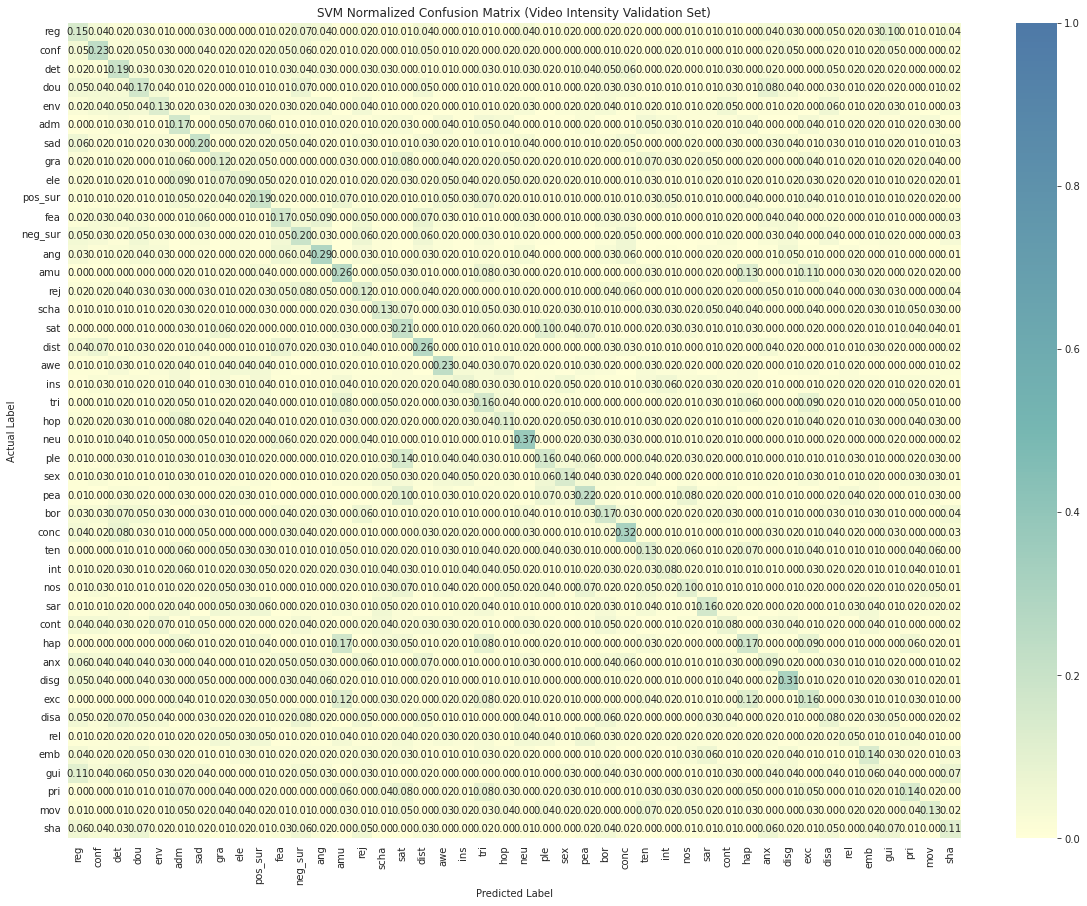

In [16]:
# Plot confusion matrix
plot_conf_matrix(df_cm, title='SVM Normalized Confusion Matrix (Video Intensity Validation Set)')

# Save confusion matrix
#plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')  